<a href="https://colab.research.google.com/github/SWE3T/TopicModeling/blob/main/SpaceNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tomotopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 14.0 MB/s eta 0:00:00


### Final project (Space news dataset)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import tomotopy as tp
import pandas as pd
import numpy as np
import string
import random
import spacy
import sys

import gensim
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases, Phraser

import nltk
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# nlp = spacy.load('en_core_web_lg')
spacy.cli.download("en_core_web_lg")
nlp = spacy.load('en_core_web_lg',  disable=["parser", "ner"])
# spacy.cli.download("en_core_web_sm")
# nlp = spacy.load('en_core_web_sm')

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
lemmatizer = WordNetLemmatizer()
english_words = set(words.words())
exclude = set(string.punctuation)
stop_words = set(stopwords.words('english'))

pd.options.mode.chained_assignment = None

Mounted at /content/drive
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


Auxiliary functions:


In [ ]:
def clean(doc):
		tokens = word_tokenize(doc)
		stop_free = [word for word in tokens if word.lower() not in stop_words]
		english_only = " ".join([w for w in stop_free if w in english_words])
		punc_free = "".join([ch for ch in english_only if ch not in exclude])
		return punc_free

def lemmatize(document):
    doc = nlp(document)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

def filter_words_with_underscore(text):
    words = text.split()
    return set([word for word in words if '_' in word])

def printTopics(model, p=None):
	for k in range(model.k):
		print('Topic #{}'.format(k))
		if p is None:
			for word, prob in model.get_topic_words(topic_id=k,top_n=10):
				print(' ', word, prob, sep=' ')
		elif p==1:
			for word, prob in model.get_topic_words(topic_id=k,top_n=10,timepoint=0):
				print(' ', word, prob, sep=' ')
		else:
			for word, prob in model.get_topic_words(sub_topic_id=k,top_n=10):
				print(' ', word, prob, sep=' ')

def printCoherence(model):
	for preset in ('u_mass', 'c_uci', 'c_npmi', 'c_v'):
		coh = tp.coherence.Coherence(model, coherence=preset)
		average_coherence = coh.get_score()
		coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]
		print('Coherence : {}'.format(preset))
		print('Average:', average_coherence, '\nper topic:', coherence_per_topic)

def runModel(model, document):
	for i,d in enumerate(document):
		model.add_doc(d)

	model.burn_in = 100
	print('Total amount of documents:', len(model.docs), ', vocabullary size:', len(model.used_vocabs), ', number of words:', model.num_words)
	print('Removed top words:', model.removed_top_words)
	for i in range(0, 100):
			model.train(3, parallel=1)
			if i % 5 == 0:
					print("Iteration: {}\t likelihood: {}".format(i, model.ll_per_word))
	model.summary()

	# print('Saving...', file=sys.stderr, flush=True)
	# model.save('test.lda.bin', True)

In [ ]:
fpath='/content/drive/MyDrive/Códigos/Modelagem de tópicos/Final Work/dataset /'

data = pd.read_csv(fpath+'spacenews-december-2022.csv')

In [ ]:
data

,title,url,content,author,date,postexcerpt
0,Orion splashes down to end Artemis 1,https://spacenews.com/orion-splashes-down-to-e...,Updated at 5:45 p.m. Eastern after post-splash...,Jeff Foust,"December 11, 2022",Fifty years to the day after the last Apollo m...
1,Polaris Dawn crewed mission could suffer addit...,https://spacenews.com/polaris-dawn-crewed-miss...,LAS VEGAS — A billionaire-backed private astro...,Jeff Foust,"October 25, 2022",A billionaire-backed private astronaut mission...
2,DART on track for asteroid collision,https://spacenews.com/dart-on-track-for-astero...,WASHINGTON — A NASA spacecraft is on course to...,Jeff Foust,"September 25, 2022",A NASA spacecraft is on course to deliberately...
3,U.S. Space Command calls for investment in tec...,https://spacenews.com/u-s-space-command-calls-...,"WASHINGTON — Lt. Gen. John Shaw, deputy comman...",Sandra Erwin,"August 31, 2022",U.S. Space Command's Lt. Gen. John Shaw said '...
4,SpaceX requests permission for direct-to-smart...,https://spacenews.com/spacex-requests-permissi...,"TAMPA, Fla. — SpaceX could provide “full and c...",Jason Rainbow,"December 8, 2022",SpaceX could provide “full and continuous” dir...
...,...,...,...,...,...,...
18349,Kendall lays out Pentagon thinking on future s...,https://spacenews.com/frank-kendall-at-wsbr/,"\nFrank Kendall, the Pentagon’s top acquisitio...",SpaceNews Staff,"February 25, 2016","Frank Kendall, the Pentagon’s top acquisition ..."
18350,A larger share of NOAA’s declining space budge...,https://spacenews.com/a-larger-share-of-noaas-...,Updated Feb. 10 at 10:18 p.m. Eastern The U.S....,Debra Werner,"February 10, 2016",The U.S. National Oceanic and Atmospheric Admi...
18351,Think Tank Turns Its Attention To Mars As 2016...,https://spacenews.com/think-tank-turns-its-att...,WASHINGTON — As NASA develops a long-term stra...,Jeff Foust,"June 11, 2015",As NASA develops a long-term strategy to suppo...
18352,House Bill Leaves Last Three JPSS Satellites i...,https://spacenews.com/no-money-for-noaa-weathe...,WASHINGTON — A spending bill the House passed ...,Dan Leone,"June 4, 2015",A spending bill the House passed June 3 would ...


It is clear that the most important feature for us is the **content**, so, let's work on it.

First of all, we can check the word count to the documents, as well as the average, min and max values:

In [ ]:
data['wordcounter'] = data['content'].apply(lambda x: len(str(x).split()))
data.describe()

,wordcounter
count,18354.000000
mean,624.801460
std,366.239719
min,0.000000
25%,388.000000
50%,593.000000
75%,781.000000
max,12555.000000


let's check if there are some missing values on it.

In [ ]:
data['content'] = data['content'].replace(r'\b\w{16,}\b|\s+|\\n', ' ', regex=True)
data.replace(' ', np.nan, inplace=True)
print(data['content'].isnull().sum())


169


In [ ]:
missing_news = data[data['content'].isnull()]

Let's check on some news where the content is missing:

In [ ]:
missing_news.sample(10)

,title,url,content,author,date,postexcerpt,wordcounter
16428,LDCM Clears Key Milestones on Way to Late 2012...,https://spacenews.com/ldcm-clears-key-mileston...,NaN,Amy Klamper,"June 14, 2010",WASHINGTON — The Landsat Data Continuity Missi...,1
13970,Orbital Trots Out Finished LDCM Spacecraft Ahe...,https://spacenews.com/32827orbital-trots-out-f...,NaN,Dan Leone,"December 14, 2012",Orbital Sciences Corp. has finished building a...,1
16227,NASA Sees Expanded Role on Euclid as Down Paym...,https://spacenews.com/nasa-sees-expanded-role-...,NaN,Amy Klamper,"September 17, 2010",WASHINGTON — NASA plans to begin preliminary w...,1
17894,Gray Eagle’s ISR mission requires high through...,https://spacenews.com/gray-eagles-isr-mission-...,NaN,Intelsat General,"December 7, 2015",The Gray Eagle is a critical part of the Army’...,1
4663,Coronavirus special coverage,https://spacenews.com/coronavirus-special-cove...,NaN,SpaceNews Staff,"March 19, 2020",SpaceNews special coverage of the novel coron...,1
13977,22 GOP Lawmakers Named to House Science Committee,https://spacenews.com/22-gop-lawmakers-named-t...,NaN,Dan Leone,"December 12, 2012",The committee’s incoming chairman announced th...,1
17295,"Op-Ed | A house divided, or in this case, a ro...",https://spacenews.com/op-ed-a-house-divided-or...,NaN,Donald F. Robertson,"November 30, 2017",Advocates of alternatives to the Apollo model ...,1
16476,NASA Reassigns Head of Constellation Program,https://spacenews.com/nasa-reassigns-head-cons...,NaN,Amy Klamper,"May 26, 2010",WASHINGTON —The top Democrat and Republican on...,1
14871,NASA Studying Human-tended Scientific Waypoint...,https://spacenews.com/nasa-studying-human-tend...,NaN,Leonard David,"February 20, 2012","GOLDEN, Colo. — NASA is assessing the value of...",1
13988,Earth’s Radiation Belts More Dynamic than Prev...,https://spacenews.com/earths-radiation-belts-m...,NaN,SpaceNews Editor,"December 10, 2012",Two new NASA probes that are flying through th...,1


These rows where there is no content available won't be very usefull for us.

Some aproaches can be used to surpass this problem, such as:

- Use the post excerpt to replace the content;
- Use the title as a replacement;
- Delete the rows with missing values.


In [ ]:
data = data.dropna(subset=['content'])
print(data['content'].isnull().sum())

0


In [ ]:
data.loc[data['wordcounter'].idxmin()]
print("This is the smallest document in the collection:")
data.loc[[10363]]

This is the smallest document in the collection:


,title,url,content,author,date,postexcerpt,wordcounter
10363,The Week Ahead for Oct. 12,https://spacenews.com/the-week-ahead-for-oct-12/,Wednesday: Wednesday-Thursday: Friday: Friday-...,SpaceNews Staff,"October 12, 2015",The 66th International Astronautical Congress ...,4


In [ ]:
data.loc[data['wordcounter'].idxmax()]
print("This is the biggest document in the collection:")
data.loc[[4649]]

This is the biggest document in the collection:


,title,url,content,author,date,postexcerpt,wordcounter
4649,The latest COVID-19 news and event updates for...,https://spacenews.com/coronavirus-space-impacts/,Follow our reporters on Twitter for updates. S...,SpaceNews Staff,"March 22, 2020",A time line of the coronavirus pandemic's impa...,12555


In [ ]:
data.at[4649, 'content']

'Follow our reporters on Twitter for updates. Sign up for our newsletters. For full stories, click here . May 8 The annual Conference on Small Satellites at Utah State University this August will become a virtual event. Conference organizers announced Friday that they shifted to a virtual format because of health and safety concerns created by the pandemic. The virtual conference will include most elements of the regular conference, such as keynote and invited speakers, oral presentations, exhibitor and sponsor information, university exhibits, poster presentations, and the Frank J. Redd Student Competition, among other aspects. Registration, which will be free of charge, will open June 1. [www.smallsat.org] May 7 Members of the European Parliament are asking for government support for Europe’s space industry because of the pandemic. Seven members of the parliament, the legislative branch of the European Union, wrote recently to Thierry Breton, a commissioner overseeing space in the Eu

The dataset contains many unecessary data that won't be used for the topic modeling;

Fields such as **url**, **author**, and **date** will be removed.

It seems that the dataset, also includes an **postexcerpt**. Which seems to be an abstract of the text that is present in the content column. Although it could be used to make a biased guess on the topic of the text, I believe it's best to dont use it for now, and use only the content of the article.


In [ ]:
data = data.drop(['url', 'date', 'author', 'postexcerpt', 'wordcounter'], axis=1)

In [ ]:
data

,title,content
0,Orion splashes down to end Artemis 1,Updated at 5:45 p.m. Eastern after post-splash...
1,Polaris Dawn crewed mission could suffer addit...,LAS VEGAS — A billionaire-backed private astro...
2,DART on track for asteroid collision,WASHINGTON — A NASA spacecraft is on course to...
3,U.S. Space Command calls for investment in tec...,"WASHINGTON — Lt. Gen. John Shaw, deputy comman..."
4,SpaceX requests permission for direct-to-smart...,"TAMPA, Fla. — SpaceX could provide “full and c..."
...,...,...
18349,Kendall lays out Pentagon thinking on future s...,"Frank Kendall, the Pentagon’s top acquisition..."
18350,A larger share of NOAA’s declining space budge...,Updated Feb. 10 at 10:18 p.m. Eastern The U.S....
18351,Think Tank Turns Its Attention To Mars As 2016...,WASHINGTON — As NASA develops a long-term stra...
18352,House Bill Leaves Last Three JPSS Satellites i...,WASHINGTON — A spending bill the House passed ...


Now, there is only two columns remaining, **title** and the **content** itself.

And we made sure that all the content column contain something,

The title will be concateneted with the content, to make it easier to use.

In [ ]:
data['content'] = data['title'] + ' ' + data['content']
data = data.drop(['title'], axis=1)

Some details about the dataset:


In [ ]:
print("Number of lines:", data.shape[0])
data

Number of lines: 18185


,content
0,Orion splashes down to end Artemis 1 Updated a...
1,Polaris Dawn crewed mission could suffer addit...
2,DART on track for asteroid collision WASHINGTO...
3,U.S. Space Command calls for investment in tec...
4,SpaceX requests permission for direct-to-smart...
...,...
18349,Kendall lays out Pentagon thinking on future s...
18350,A larger share of NOAA’s declining space budge...
18351,Think Tank Turns Its Attention To Mars As 2016...
18352,House Bill Leaves Last Three JPSS Satellites i...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18185 entries, 0 to 18353
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  18185 non-null  object
dtypes: object(1)
memory usage: 800.2+ KB


### Now, for the data treatment part:


In [ ]:
# For testing purposes, this line set data to be a part of the dataset;
# data = data[:250]
data

,content
0,Orion splashes down to end Artemis 1 Updated a...
1,Polaris Dawn crewed mission could suffer addit...
2,DART on track for asteroid collision WASHINGTO...
3,U.S. Space Command calls for investment in tec...
4,SpaceX requests permission for direct-to-smart...
...,...
18349,Kendall lays out Pentagon thinking on future s...
18350,A larger share of NOAA’s declining space budge...
18351,Think Tank Turns Its Attention To Mars As 2016...
18352,House Bill Leaves Last Three JPSS Satellites i...


Now, this part of the code, removes from the documents **ponctuation**, **stop words** and non **english** words

In [ ]:
data['tokens'] = data['content'].apply(lambda x: clean(x))
data

,content,tokens
0,Orion splashes down to end Artemis 1 Updated a...,Orion end Artemis Eastern briefing day last Ap...
1,Polaris Dawn crewed mission could suffer addit...,Polaris Dawn mission could suffer additional p...
2,DART on track for asteroid collision WASHINGTO...,track asteroid collision course deliberately c...
3,U.S. Space Command calls for investment in tec...,Space investment deep space John Shaw deputy c...
4,SpaceX requests permission for direct-to-smart...,permission service could provide full continuo...
...,...,...
18349,Kendall lays out Pentagon thinking on future s...,thinking future space Frank top acquisition of...
18350,A larger share of NOAA’s declining space budge...,share space budget would go polar Eastern camp...
18351,Think Tank Turns Its Attention To Mars As 2016...,Think Mars strategy support human Mars one thi...
18352,House Bill Leaves Last Three JPSS Satellites i...,Bill spending bill June would give billion cen...


And here, we generate the bigrams.

In [ ]:
data['tokens'] = data['tokens'].apply(word_tokenize)

sentences = data['tokens'].tolist()

bigram_model = Phrases(sentences, min_count=4)
bigram_phraser = Phraser(bigram_model)

def apply_bigrams(tokens):
    return ' '.join(list(bigram_phraser[tokens]))

data['tokens'] = data['tokens'].apply(apply_bigrams)

In [ ]:
data['bigrams'] = data['tokens'].apply(lambda x: filter_words_with_underscore(x))
data

,content,tokens,bigrams
0,Orion splashes down to end Artemis 1 Updated a...,Orion end Artemis Eastern briefing day last Ap...,"{sixth_final, harder_harder, program_manager, ..."
1,Polaris Dawn crewed mission could suffer addit...,Polaris_Dawn mission could suffer additional p...,"{take_seriously, Polaris_Dawn, pending_outcome..."
2,DART on track for asteroid collision WASHINGTO...,track asteroid collision_course deliberately c...,"{adjust_trajectory, lead_engineer, extremely_i..."
3,U.S. Space Command calls for investment in tec...,Space investment deep_space John_Shaw deputy_c...,"{Cape_Florida, deep_space, right_balance, mach..."
4,SpaceX requests permission for direct-to-smart...,permission service could provide full continuo...,"{continuous_coverage, wrote_letter, per_second..."
...,...,...,...
18349,Kendall lays out Pentagon thinking on future s...,thinking future space Frank top acquisition of...,"{end_reliance, key_player, missile_warning, te..."
18350,A larger share of NOAA’s declining space budge...,share space budget would go polar Eastern camp...,"{next_year, growing_interest, coronal_mass, po..."
18351,Think Tank Turns Its Attention To Mars As 2016...,Think Mars strategy support human Mars one thi...,"{policy_analyst, senior_fellow, proving_ground..."
18352,House Bill Leaves Last Three JPSS Satellites i...,Bill spending_bill June would give billion cen...,"{roughly_billion, split_evenly, budget_request..."


I've created a new column to keep track of the original text, as well as the bigrams that were generated;

Now, we apply the lemmatizer, to transform words into a more recognizable version of the word.

In [ ]:
data['tokens'] = data['tokens'].apply(lemmatize)

The bigrams column wont be used for training the model, only for showing puposes. But the tokens already have the bigrams converted in then.

In [ ]:
data['tokens'] = data['tokens'].apply(word_tokenize)

dictionary = Dictionary(data['tokens'])

dictionary.filter_extremes(no_below=7, no_above=0.75)

data['tokens'] = data['tokens'].apply(lambda x: [token for token in x if token in dictionary.token2id])

In [ ]:
data

,content,tokens,bigrams
0,Orion splashes down to end Artemis 1 Updated a...,"[orion, end, Artemis, Eastern, briefing, day, ...","{sixth_final, harder_harder, program_manager, ..."
1,Polaris Dawn crewed mission could suffer addit...,"[mission, could, suffer, additional, private_a...","{take_seriously, Polaris_Dawn, pending_outcome..."
2,DART on track for asteroid collision WASHINGTO...,"[track, asteroid, collision_course, deliberate...","{adjust_trajectory, lead_engineer, extremely_i..."
3,U.S. Space Command calls for investment in tec...,"[space, investment, deep_space, john_shaw, dep...","{Cape_Florida, deep_space, right_balance, mach..."
4,SpaceX requests permission for direct-to-smart...,"[permission, service, could, provide, full, co...","{continuous_coverage, wrote_letter, per_second..."
...,...,...,...
18349,Kendall lays out Pentagon thinking on future s...,"[think, future, space, Frank, top, acquisition...","{end_reliance, key_player, missile_warning, te..."
18350,A larger share of NOAA’s declining space budge...,"[share, space, budget, would, go, polar, easte...","{next_year, growing_interest, coronal_mass, po..."
18351,Think Tank Turns Its Attention To Mars As 2016...,"[think, Mars, strategy, support, human, Mars, ...","{policy_analyst, senior_fellow, proving_ground..."
18352,House Bill Leaves Last Three JPSS Satellites i...,"[Bill, spending_bill, June, would, give, billi...","{roughly_billion, split_evenly, budget_request..."


### We have our data treated; It is time to start training our model to extract the topics

###About the model:

The DMR (Dirichlet Multinomial Regression) model is a probabilistic topic modeling algorithm that combines the strengths of topic models, such as Latent Dirichlet Allocation (LDA), with regression analysis. It is designed to discover latent topics in a collection of documents and understand their relationships with external variables or covariates.



This code runs the model with different combination in order to find the best candidate to the hyperparamethers; It takes a lot of time to calculate it, because it runs through the model multiple times.

In [ ]:
# num_topics_list = [10, 15, 20, 25, 30, 40]
# alpha_list = [0.2, 0.4, 0.5, 0.7, 1.0]
# beta_list = [0.2, 0.4, 0.5, 0.7, 1.0]
# rm_list = [5, 15, 23, 30, 40, 50]

# best_params = {}

# list_of_scores = []

# for num_topics in num_topics_list:
#     for alpha in alpha_list:
#         for rm in rm_list:
#             for beta in beta_list:
#                 model = tp.DMRModel(
#                     k=num_topics,
#                     alpha=alpha,
#                     eta=beta,
#                     rm_top=rm
#                 )

#                 for doc in data['tokens']:
#                     model.add_doc(doc)
#                 for i in range(0, 100, 10):
#                     model.train(10)

#                 coh = tp.coherence.Coherence(model, coherence='c_v')
#                 average_coherence = coh.get_score()
#                 if len(list_of_scores) > 0:
#                   if average_coherence > max(list_of_scores):
#                     best_params = {'num_topics': num_topics, 'alpha': alpha, 'beta': beta, 'average': average_coherence}

#                 list_of_scores.append(average_coherence)

# print("Best hyperparamethers found:", best_params)

In [ ]:
# tries = 50

# list_of_scores = []
# best_params = {}

# num_topics_list = [30, 40, 50]
# alpha_list = [0.7,0.8, 0.9, 1.0]
# beta_list = [0.1, 0.2, 0.075, 1.0]
# min_list = [25, 35, 45]
# rm_list = [30, 40, 50]

# t = 0
# while t < tries:
#   t += 1

#   min_cf=random.sample(min_list, 1)[0],
#   min_df=random.sample(min_list, 1)[0],
#   k=random.sample(num_topics_list, 1)[0],
#   alpha=random.sample(alpha_list, 1)[0],
#   eta=random.sample(beta_list, 1)[0],
#   rm_top=random.sample(rm_list, 1)[0],

#   model = tp.DMRModel(
#       min_cf=min_cf[0],
#       min_df=min_df[0],
#       k=k[0],
#       alpha=alpha[0],
#       eta=eta[0],
#       rm_top=rm_top[0],
#       seed=1441
#   )

#   for doc in data['tokens']:
#       model.add_doc(doc)

#   for i in range(0, 500, 5):
#       model.train(5)

#   coh = tp.coherence.Coherence(model, coherence='c_v')
#   average_coherence = coh.get_score()
#   print("This preset score: \t", average_coherence, '\tmin_cf: ',min_cf[0],' min_df: ',min_df[0],' k: ',k[0],' alpha: ',alpha[0],' eta: ',eta[0],' rm_top: ',rm_top[0])

#   if len(list_of_scores) > 0:
#     if average_coherence > max(list_of_scores):
#       best_params = {'coherence': average_coherence, 'min_cf': min_cf[0],'min_df': min_df[0],'k': k[0],'alpha': alpha[0],'eta': eta[0],'rm_top': rm_top[0]}
#   else:
#     best_params = {'coherence': average_coherence, 'min_cf': min_cf[0],'min_df': min_df[0],'k': k[0],'alpha': alpha[0],'eta': eta[0],'rm_top': rm_top[0]}

#   list_of_scores.append(average_coherence)

# print("Best hyperparamethers found:", best_params)

In [ ]:
 # model = tp.DMRModel(tw=tp.TermWeight.IDF, min_cf=3, min_df=3, rm_top=6, k=best_params['num_topics'], alpha=best_params['alpha'], eta=best_params['beta'], seed=777)
model = tp.DMRModel(tw=tp.TermWeight.IDF, min_cf=14, min_df=3, rm_top=11, k=23, alpha=0.95, eta=0.01, seed=57631827)

# Best hyperparamethers found: {'num_topics': 40, 'alpha': 0.2, 'beta': 1.0, 'average': 0.8982045617699626}
runModel(model, data['tokens'])

Total amount of documents: 18183 , vocabullary size: 0 , number of words: 0
Removed top words: ['orion_lifeboat', 'plan_scrap', 'magazine_every', 'column_ran', 'greatness', 'journalist_base', 'peace_prosperity', 'expressed_author', 'bodyguard', 'Brian_independent', 'commentary_originally']


<ipython-input-3-78ad9abe1c48>:46: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(3, parallel=1)


Iteration: 0	 likelihood: -10.67624338324341
Iteration: 5	 likelihood: -9.262687727240394
Iteration: 10	 likelihood: -9.026734629328734
Iteration: 15	 likelihood: -8.944740001841998
Iteration: 20	 likelihood: -8.899708727306738
Iteration: 25	 likelihood: -8.871071035892808
Iteration: 30	 likelihood: -8.848620983040107
Iteration: 35	 likelihood: -8.829154747809618
Iteration: 40	 likelihood: -8.696569370643937
Iteration: 45	 likelihood: -8.677224131806279
Iteration: 50	 likelihood: -8.661903560375869
Iteration: 55	 likelihood: -8.649822403010386
Iteration: 60	 likelihood: -8.638821834949656
Iteration: 65	 likelihood: -8.629939999897717
Iteration: 70	 likelihood: -8.62075380913373
Iteration: 75	 likelihood: -8.612769356620802
Iteration: 80	 likelihood: -8.607260625545635
Iteration: 85	 likelihood: -8.603158580138109
Iteration: 90	 likelihood: -8.597502384863933
Iteration: 95	 likelihood: -8.592298081159866
<Basic Info>
| DMRModel (current version: 0.12.4)
| 18183 docs, 3128933 words
| Tot

In [ ]:
printCoherence(model)

Coherence : u_mass
Average: -1.9098474771702227 
per topic: [-2.222960318467231, -2.083552924604005, -0.9850017692881716, -1.400442682903789, -2.391883574566805, -2.182522467197275, -1.536766735426315, -1.7889475062744185, -2.1717412811853603, -2.383347615479935, -2.050030748810337, -2.081741748549998, -1.6300855966593386, -1.970473465568253, -1.8660479589541266, -2.1407669818312973, -1.4862667009762969, -1.51205796277738, -2.2974113257152347, -1.183367497059573, -1.9734037016228294, -2.5753811234036497, -2.0122902875935136]
Coherence : c_uci
Average: 0.6212778218089222 
per topic: [1.293715138773121, 1.097928670455726, 0.9656714233087159, 0.7899329687413765, 0.375902293737846, 1.2857408771586665, 1.4289223305489893, -0.9740963062892335, 0.8996438548968337, -0.9120551752451868, 0.7461915019377457, 0.35513277328779735, 0.9588290258240868, 1.4812218489632665, 0.7362096052034447, 0.2147907347178853, 0.8702276565314752, 1.2965152217465488, 0.06117257614233544, 0.10729288493998658, 0.725743

Last things to do:

- Label the topics;
- Rank the most relevant topics in the document;


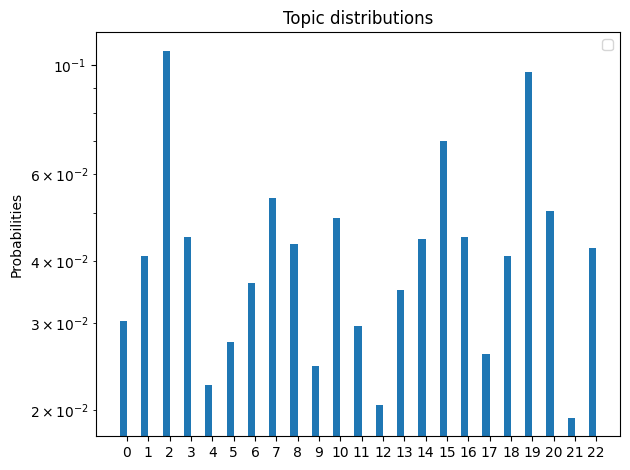

In [ ]:
import matplotlib.pyplot as plt

probs = np.exp(model.lambdas - model.lambdas.max(axis=0))
probs /= probs.sum(axis=0)

x = np.arange(model.k)
width = 1 / (model.f + 2)

fig, ax = plt.subplots()
for f, metadata_name in enumerate(model.metadata_dict):
    ax.bar(x + width * (f - model.f / 2), probs[:, f], width, label=model.metadata_dict[f])

ax.set_ylabel('Probabilities')
ax.set_yscale('log')
ax.set_title('Topic distributions')
ax.set_xticks(x)
ax.set_xticklabels(['{}'.format(k) for k in range(model.k)])
ax.legend()

fig.tight_layout()
plt.show()

In [ ]:
threshold = 0.6
samples = 1

topic_count = {}

topics_graph = []
document_counts_graph = []

sample_document = ()

for index, doc in enumerate(model.docs):
    topic_distribution = doc.get_topic_dist()
    for topic, score in enumerate(topic_distribution):
        if score >= threshold:
            if topic not in topic_count:
                topic_count[topic] = 1
            else:
                topic_count[topic] += 1

            if score > 0.8 and samples > 0 and topic == 22:
              samples =- 1
              # print("Sample: ", index, topic)
              sample_document = (index, topic)

sorted_topics = sorted(topic_count.items(), key=lambda x: x[1], reverse=True)

for topic, count in sorted_topics:
    document_counts_graph.append(count)
    topics_graph.append(topic)
    print(f"Topic {topic}: {count} documents")

Topic 22: 317 documents
Topic 20: 211 documents
Topic 14: 189 documents
Topic 16: 159 documents
Topic 7: 131 documents
Topic 5: 118 documents
Topic 11: 118 documents
Topic 1: 95 documents
Topic 6: 82 documents
Topic 12: 81 documents
Topic 13: 76 documents
Topic 0: 69 documents
Topic 3: 60 documents
Topic 4: 33 documents
Topic 18: 25 documents
Topic 10: 23 documents
Topic 17: 23 documents
Topic 19: 23 documents
Topic 8: 19 documents
Topic 9: 7 documents
Topic 15: 3 documents
Topic 21: 2 documents
Topic 2: 1 documents


In [ ]:
print('Sample topic document', sample_document[1])

data.at[sample_document[0], 'content']

Sample topic document 22


'Sea Launch platform to leave California • Hispasat boosts Red Eléctrica’s financials TOP STORIES Sea Launch’s mobile Odyssey launchpad was loaded onto a cargo ship, the Xin Guang Hua , for transport from California . The 46,000-ton launchpad, last used in 2014, is expected to arrive near Vladivostok, Russia, in March . Russian aviation company S7 Group completed its purchase of Sea Launch in 2018. [Gazettes/TASS/@MXSOCAL] EchoStar, Khosla Ventures and OneWeb founder Greg Wyler have invested an additional $24 million into Tarana Wireless, a California startup developing technology for long-distance wireless links. Tarana said the funds will help further a demonstration network in Silicon Valley that links multiple locations up to 15 kilometers away using a single transmitter, many without direct line of sight. Tarana said investors have committed to provide another $36 million in equity investment through October. [Tarana Wireless] Spanish power company Red Eléctrica says its acquisiti

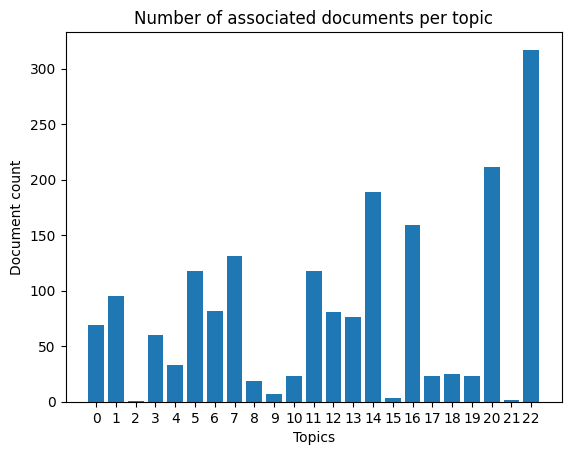

In [ ]:
plt.bar(topics_graph, document_counts_graph)
plt.xlabel('Topics')
plt.ylabel('Document count')
plt.title('Number of associated documents per topic')
plt.xticks(topics_graph)
plt.show()

In [ ]:
printTopics(model)

 22 : Spectrum of business in capacity revenue

 20 : Engine award for Atlas Martian contract

 14 : Investigation of a test flight failure

 16 : Test of a first stage rocket engine  

 7 : Russian rocket contract failure

 5 : Telescopic view of planets

 11 : Acquisition of military defense components

 6 : Space station cargo flight

 12 : Nomination of a administrator director

 13 : Committee of budget administration